In [53]:
import pandas as pd
import numpy as np
import matplotlib as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [54]:
df=pd.read_csv("../data/Training_Set_Values.csv")       # Read the Training data CSV file
name_featrures=df.columns                       # Get the features name
len_features=len(name_featrures)                # Get the length of features
labels=pd.read_csv("../data/Training_Set_labels.csv")   # Read the labels (target) CSV file
labels.head()
df['target'] = labels['status_group']   

In [55]:
# Columns to be dropped for the baseline models
columns_to_drop=['id','num_private','recorded_by','scheme_name',
              'extraction_type_group','extraction_type',
              'management','payment_type','quality_group','quantity_group','source','waterpoint_type_group',
              'funder','installer']

df = df.drop(columns=columns_to_drop)

#X_test = X_test.drop(columns=columns_to_drop)
#X_train = X_train.drop(columns=columns_to_drop)

In [56]:
# Convert the target column to labels 
#print(df['target'].unique())
target_map_dict={'functional': 2, 'functional needs repair': 1, 'non functional': 0} # Defined the mapping of labels to numbers (integers)
#print(df['target'].head())
df['target'] =df['target'].map(target_map_dict) # transform the target column (labels) to  numbers (integers)
#df['target'].head()

In [57]:
X = df.drop(columns=['target'])  # Features only
y = df['target']                 # Target column

In [58]:
from sklearn.model_selection import train_test_split

# Replace with your actual target column name
#target_col = 'status_group'  # Example: use your actual label column
#
#X = df.drop(columns=[target_col])  # Drop target and ID from features
#y = df[target_col]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y
)


In [89]:
# Re-imports after code execution environment reset
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy.sparse import issparse
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import KFold

# Re-defining all custom transformers
class StringConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names = X.columns
        return self
    def transform(self, X):
        return X.apply(lambda col: col.astype(str))
    def get_feature_names_out(self, input_features=None):
        return self.feature_names

class YearExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        return self
    def transform(self, X):
        years = pd.to_datetime(X.iloc[:, 0]).dt.year
        years = years.where(years.isin([2011, 2012, 2013]), 2011)
        return pd.DataFrame(years, columns=[self.feature_name])
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='clip', multiplier=1.5):
        self.strategy = strategy
        self.multiplier = multiplier
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        X_series = X.iloc[:, 0]
        self.q1 = X_series.quantile(0.25)
        self.q3 = X_series.quantile(0.75)
        self.iqr = self.q3 - self.q1
        self.lower_bound = self.q1 - self.multiplier * self.iqr
        self.upper_bound = self.q3 + self.multiplier * self.iqr
        self.mean = X_series.mean()
        self.median = X_series.median()
        return self
    def transform(self, X):
        X_series = X.iloc[:, 0].copy()
        if self.strategy == 'clip':
            X_out = X_series.clip(self.lower_bound, self.upper_bound)
        elif self.strategy == 'mean':
            mask = (X_series < self.lower_bound) | (X_series > self.upper_bound)
            X_out = X_series.mask(mask, self.mean)
        elif self.strategy == 'median':
            mask = (X_series < self.lower_bound) | (X_series > self.upper_bound)
            X_out = X_series.mask(mask, self.median)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        return pd.DataFrame(X_out, columns=[self.feature_name])
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class ConstructionYearTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        self.median_non_zero = X[X[self.feature_name] != 0][self.feature_name].median()
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.feature_name] = X_copy[self.feature_name].replace(0, self.median_non_zero)
        return X_copy
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class ObjectToNumericConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if hasattr(X, 'columns'):
            X_copy = X.copy()
            for col in X_copy.columns:
                if X_copy[col].dtype == 'object':
                    try:
                        X_copy[col] = pd.to_numeric(X_copy[col])
                    except ValueError:
                        pass
            return X_copy
        else:
            return X  # already numeric


    def get_feature_names_out(self, input_features=None):
        return self.feature_names


class AgeCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, record_col='date_recorded', install_col='construction_year'):
        self.record_col = record_col
        self.install_col = install_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        record_year = pd.to_datetime(X[self.record_col]).dt.year
        age = record_year - X[self.install_col]
        return pd.DataFrame({'age': age})

    def get_feature_names_out(self, input_features=None):
        return ['age']


class RegionCodeCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, region_col='region', code_col='region_code', new_col='region_with_code'):
        self.region_col = region_col
        self.code_col = code_col
        self.new_col = new_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_col] = X[self.region_col].astype(str) + "_" + X[self.code_col].astype(str)
        return X


class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.columns_to_drop:
            return X.drop(columns=[col for col in self.columns_to_drop if col in X.columns])
        return X

class GeoContextImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.geo_group_cols = ['subvillage', 'ward', 'lga', 'district_code', 'region_code']
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        if 'subvillage' in X.columns:
            X['subvillage'] = X['subvillage'].replace('', pd.NA)
            X['subvillage'] = X.apply(lambda row: self.fill_subvillage(row, X), axis=1)
        for col in ['latitude', 'longitude']:
            if col in X.columns:
                X[col] = X[col].apply(lambda x: pd.NA if abs(x) < 1e-6 else x)
        if 'latitude' in X.columns and 'longitude' in X.columns:
            X = self.fill_missing_geo(X, self.geo_group_cols)
        if 'population' in X.columns:
            X['population'] = X['population'].apply(lambda x: pd.NA if x in [0, 1] else x)
            X = self.geo_groupwise_fill(X, 'population', self.geo_group_cols)
        if 'amount_tsh' in X.columns:
            X['amount_tsh'] = X['amount_tsh'].apply(lambda x: pd.NA if x in [0, 1] else x)
            X = self.geo_groupwise_fill(X, 'amount_tsh', self.geo_group_cols)
        if 'permit' in X.columns:
            X = self.geo_groupwise_fill_mode(X, 'permit', self.geo_group_cols)
        if 'public_meeting' in X.columns:
            X = self.geo_groupwise_fill_mode(X, 'public_meeting', self.geo_group_cols)
        if 'gps_height' in X.columns:
            X['gps_height'] = X['gps_height'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill(X, 'gps_height', self.geo_group_cols)
        if 'construction_year' in X.columns:
            X['construction_year'] = X['construction_year'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill_mode(X, 'construction_year', self.geo_group_cols)
        if 'wpt_name' in X.columns:
            X['wpt_name'] = X['wpt_name'].fillna('none')
        if 'scheme_management' in X.columns:
            X['scheme_management'] = X['scheme_management'].fillna('other')
        for col in ['funder', 'installer', 'scheme_name']:
            if col in X.columns:
                X = self.relabel_by_coverage(X, col, threshold=0.5)
        return X.replace({pd.NA: np.nan})

    def fill_subvillage(self, row, df):
        if pd.isna(row['subvillage']):
            for level in ['ward', 'lga', 'district_code']:
                mode = df[df[level] == row[level]]['subvillage'].mode()
                if not mode.empty:
                    return mode[0]
            return 'unknown'
        return row['subvillage']

    def fill_missing_geo(self, df, group_cols):
        for col in group_cols:
            group_means = df.dropna(subset=['latitude', 'longitude']).groupby(col)[['latitude', 'longitude']].mean()
            def fill(row):
                if pd.isna(row['latitude']) or pd.isna(row['longitude']):
                    key = row[col]
                    if key in group_means.index:
                        if pd.isna(row['latitude']):
                            row['latitude'] = group_means.loc[key, 'latitude']
                        if pd.isna(row['longitude']):
                            row['longitude'] = group_means.loc[key, 'longitude']
                return row
            df = df.apply(fill, axis=1)
            if df['latitude'].isna().sum() == 0 and df['longitude'].isna().sum() == 0:
                break
        return df

    def geo_groupwise_fill(self, df, target_col, group_cols):
        for col in group_cols:
            group_medians = df.dropna(subset=[target_col]).groupby(col)[target_col].median()
            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_medians.index:
                        row[target_col] = group_medians.loc[key]
                return row
            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break
        return df

    def geo_groupwise_fill_mode(self, df, target_col, group_cols):
        for col in group_cols:
            group_modes = df.dropna(subset=[target_col]).groupby(col)[target_col].agg(lambda x: x.mode().iloc[0])
            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_modes.index:
                        row[target_col] = group_modes.loc[key]
                return row
            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break
        return df

    def relabel_by_coverage(self, df, column, threshold=0.5, new_label='other'):
        value_counts = df[column].value_counts(normalize=True)
        cumulative = value_counts.cumsum()
        keep_labels = cumulative[cumulative <= threshold].index.tolist()
        df[column] = df[column].apply(lambda x: x if x in keep_labels else new_label)
        return df


In [156]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SklearnPipeline


# 1. Initial preprocessing (geo imputation + drop columns)
columns_to_drop=['id','num_private','recorded_by',
              'extraction_type_group','extraction_type',
              'quality_group','quantity_group','source','waterpoint_type_group',
                 'region', 
                 #'wpt_name','scheme_management', 'funder', 'installer','scheme_name', 'payment', 'public_meeting', 'permit',
              'subvillage', 'ward','lga']

initial_preprocessing = Pipeline([
    ('geo_imputer', GeoContextImputer()),
    ('region_combiner', RegionCodeCombiner()),  # <- Add this
    ('dropper', ColumnDropper(columns_to_drop=columns_to_drop))
])
# Step 2: Apply initial transformation
intermediate = initial_preprocessing.fit_transform(X_train.copy())
numeric_features = intermediate.select_dtypes(include='number').columns.tolist()
categorical_features = intermediate.select_dtypes(include='object').columns.tolist()

#adding the two features to caregorical explicitly, and removing from numerical.
categorical_features.append('region_with_code')
categorical_features.append('district_code')

if 'district_code' in numeric_features:
    numeric_features.remove('district_code')

if 'region_code' in numeric_features:
    numeric_features.remove('region_code')

#⚠️ Remove columns used by age pipeline so they are not reused elsewhere
for col in ['date_recorded']:
    if col in numeric_features:
        numeric_features.remove(col)
    if col in categorical_features:
        categorical_features.remove(col)

# ✅ De-duplicate and check overlaps between numeric and categorical
categorical_features = list(set(categorical_features))  # Remove duplicates
numeric_features = list(set(numeric_features))          # Optional: do the same for numeric
assert not set(numeric_features) & set(categorical_features), "❌ Overlap between numeric and categorical features"


#for col in ['funder']:
#    if col in numeric_features:
#        numeric_features.remove(col)
#    if col in categorical_features:
#        categorical_features.remove(col)


# 3. Build per-type transformers
numeric_transformer = Pipeline([
    ('iqr_cap', IQRCapper(strategy='clip')),
    ('scaler', StandardScaler())
])

class AgePipeline(SklearnPipeline):
    def get_feature_names_out(self, input_features=None):
        return ['age']

age_pipeline = AgePipeline([
    ('age_calc', AgeCalculator()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('string_converter', StringConverter()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Use sparse=False if needed
])

# 4. Assemble preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['date_recorded', 'construction_year']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    sparse_threshold=0,
    verbose_feature_names_out=True  # 👈 add this
)



# Insert it into the pipeline
full_pipeline = Pipeline([
    ('geo_imputer', GeoContextImputer()),
    ('region_combiner', RegionCodeCombiner()),
    ('dropper', ColumnDropper(columns_to_drop=columns_to_drop)),
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', n_jobs= -1))
])


In [157]:
full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [158]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.775645342312009


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("Average CV accuracy:", scores.mean())


In [159]:
# 1. Get the trained RandomForestClassifier
rf_model = full_pipeline.named_steps['classifier']

# 2. Get the ColumnTransformer directly
column_transformer = full_pipeline.named_steps['preprocessor']

# 3. Initialize feature name list
feature_names = []

# 4. Loop through transformers
# 4. Loop through transformers
for name, transformer, cols in column_transformer.transformers_:
    if name == 'cat':  # Categorical pipeline with OneHotEncoder
        ohe = transformer.named_steps['ohe']
        ohe_feature_names = ohe.get_feature_names_out(cols)
        feature_names.extend(ohe_feature_names)
    elif name == 'num':  # Numerical pipeline
        feature_names.extend(cols)
    elif name == 'age':  # ✅ Include age pipeline
        if hasattr(transformer, 'get_feature_names_out'):
            age_feature_names = transformer.get_feature_names_out()
        else:
            age_feature_names = ['age']
        # Prefix with 'age__' for consistency with ColumnTransformer
        feature_names.extend(['age__' + fname for fname in age_feature_names])
    elif name == 'remainder' and transformer == 'passthrough':
        feature_names.extend(cols)


# 5. Combine with feature importances
importances = rf_model.feature_importances_
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# 6. Display top features
print("🔝 Top 30 Feature Importances:")
for name, score in feature_importances[:30]:
    print(f"{name}: {score:.4f}")


🔝 Top 30 Feature Importances:
age__age: 0.0642
amount_tsh: 0.0474
region_with_code_Shinyanga_17: 0.0338
region_with_code_Singida_13: 0.0183
basin_Rufiji: 0.0165
waterpoint_type_communal standpipe: 0.0157
waterpoint_type_other: 0.0134
quantity_unknown: 0.0129
scheme_management_WUA: 0.0125
source_class_surface: 0.0109
scheme_management_Other: 0.0101
payment_other: 0.0096
basin_Lake Victoria: 0.0091
management_group_user-group: 0.0087
source_type_dam: 0.0087
water_quality_fluoride: 0.0087
extraction_type_class_wind-powered: 0.0085
region_with_code_Tanga_5: 0.0085
scheme_management_WUG: 0.0080
management_group_parastatal: 0.0080
scheme_management_Water authority: 0.0079
region_with_code_Tabora_14: 0.0078
water_quality_soft: 0.0074
district_code_2: 0.0073
extraction_type_class_submersible: 0.0072
basin_Wami / Ruvu: 0.0071
waterpoint_type_improved spring: 0.0066
wpt_name_Shule/Msingi: 0.0062
quantity_seasonal: 0.0061
source_type_shallow well: 0.0059


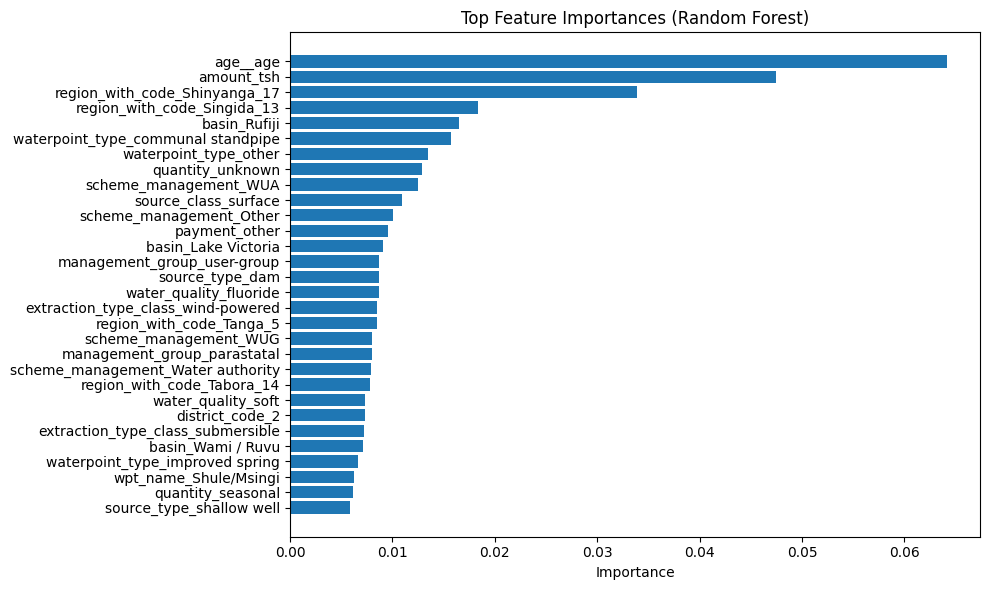

In [160]:
import matplotlib.pyplot as plt

top_n = 30
names, scores = zip(*feature_importances[:top_n])

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], scores[::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Time to bring in the actual test set for making the submission to the competiton

In [95]:
df_3 = pd.read_csv("../data/Test_Set_Values.csv")

In [92]:
X_test_ids = df_3['id'].copy()  # Store before dropping

In [96]:
preds_test = full_pipeline.predict(df_3)

/tmp/ipykernel_8967/2354782563.py:173: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace({pd.NA: np.nan})
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [103]:
# Correctly map ints to strings
reverse_target_map = {0: 'non functional', 1: 'functional needs repair', 2: 'functional'}
y_pred_labels = [reverse_target_map[int(p)] for p in preds_test]  # Ensure int keys

# Create DataFrame
submission = pd.DataFrame({
    "id": X_test_ids.values,
    "status_group": y_pred_labels
})
submission.to_csv("submission.csv", index=False)


Submitting resut on drivendata with testset, public score = 0.76

In [24]:
##RANDOMIZED SEACRH

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(100, 1000)
}

random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=50,             # Try 50 combinations
    cv=5,
    scoring='balanced_accuracy',    # or 'f1_macro', etc.
    random_state=42,
    n_jobs=-1,
    verbose=2
)


In [16]:
#GridSearch

from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

grid = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # or 'f1_macro', etc.
    n_jobs=-1,  # parallel processing
    verbose=2
)

Optimization using gridsearch

In [17]:
grid.fit(X_train, y_train_encoded)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Predict using the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................classifier__n_estimators=100; total time= 3.1min
[CV] END .......................classifier__n_estimators=300; total time= 5.1min
[CV] END .......................classifier__n_estimators=600; total time= 8.0min


/home/amey/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .......................classifier__n_estimators=100; total time= 3.1min
[CV] END .......................classifier__n_estimators=300; total time= 5.2min
[CV] END .......................classifier__n_estimators=600; total time= 8.0min
[CV] END .......................classifier__n_estimators=100; total time= 3.2min
[CV] END .......................classifier__n_estimators=400; total time= 6.1min
[CV] END .......................classifier__n_estimators=600; total time= 8.1min
[CV] END .......................classifier__n_estimators=100; total time= 3.1min
[CV] END .......................classifier__n_estimators=400; total time= 6.2min
[CV] END .......................classifier__n_estimators=600; total time= 8.2min
[CV] END .......................classifier__n_estimators=200; total time= 4.1min
[CV] END .......................classifier__n_estimators=400; total time= 6.2min
[CV] END .......................classifier__n_estimators=600; total time= 8.1min
[CV] END ...................

In [26]:
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 40, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 620}
Best cross-validation score: 0.7018965084294856


Evaluation metrics

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


📊 Accuracy: 0.775645342312009
🎯 Precision (macro): 0.6886864851293896
🎯 Recall (macro): 0.6377083691288242
🎯 F1 Score (macro): 0.6559639375395365
🎯 F1 Score (weighted): 0.7690941412718203
🧠 Cohen’s Kappa: 0.5808373580447026
📉 Log Loss: 0.6053320685943674
📈 ROC AUC Score (OvR): 0.8777917000799419

🧾 Classification Report:
                         precision    recall  f1-score   support

         non functional       0.80      0.74      0.77      3424
functional needs repair       0.48      0.31      0.38       647
             functional       0.78      0.86      0.82      4839

               accuracy                           0.78      8910
              macro avg       0.69      0.64      0.66      8910
           weighted avg       0.77      0.78      0.77      8910



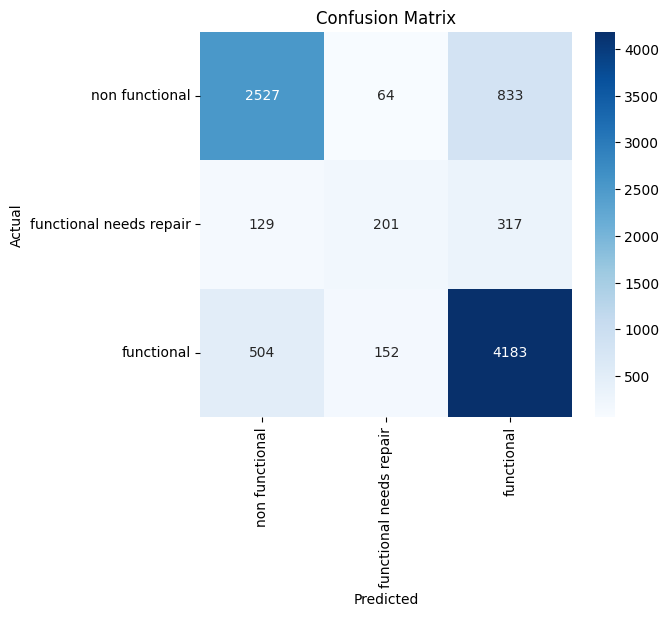


🔍 Class distribution comparison:
Predicted: 0    0.354658
1    0.046801
2    0.598541
Name: proportion, dtype: float64
True:      target
0    0.384287
1    0.072615
2    0.543098
Name: proportion, dtype: float64


In [161]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, log_loss,
    roc_auc_score, cohen_kappa_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

inv_target_map = {v: k for k, v in target_map_dict.items()}
class_names = [inv_target_map[i] for i in sorted(inv_target_map)]

# Label decoding if needed
y_true = y_test
y_pred_labels = y_pred  # use inverse_transform(y_pred) if label encoded
y_proba = full_pipeline.predict_proba(X_test)  # must be available for log_loss/roc_auc

# Basic Scores
print("📊 Accuracy:", accuracy_score(y_true, y_pred_labels))
print("🎯 Precision (macro):", precision_score(y_true, y_pred_labels, average='macro'))
print("🎯 Recall (macro):", recall_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (macro):", f1_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (weighted):", f1_score(y_true, y_pred_labels, average='weighted'))

# Cohen's Kappa
print("🧠 Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred_labels))

# Log Loss (requires probabilities)
try:
    print("📉 Log Loss:", log_loss(y_true, y_proba))
except:
    print("⚠️ Log loss not available (no predict_proba)")

# ROC AUC (multiclass)
try:
    print("📈 ROC AUC Score (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))
except:
    print("⚠️ ROC AUC not available (no predict_proba)")

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Prediction Distribution vs True Distribution
print("\n🔍 Class distribution comparison:")
print("Predicted:", pd.Series(y_pred_labels).value_counts(normalize=True).sort_index())
print("True:     ", pd.Series(y_true).value_counts(normalize=True).sort_index())


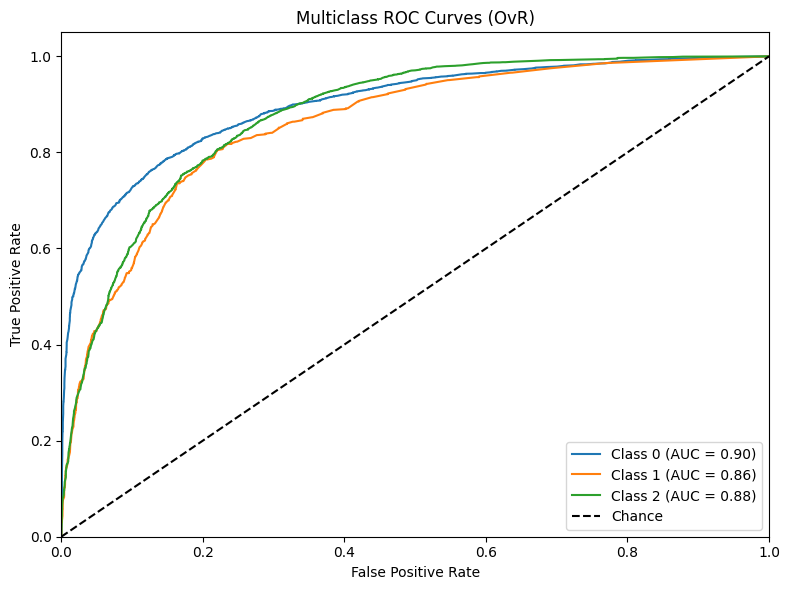

In [162]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming y_true (integer labels) and y_proba (n_samples x n_classes)
# Also, target_map_dict = {'functional': 2, 'functional needs repair': 1, 'non functional': 0}
# Reverse map and binarize
classes = [0, 1, 2]  # or sorted list(target_map_dict.values())
y_test_bin = label_binarize(y_true, classes=classes)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (OvR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


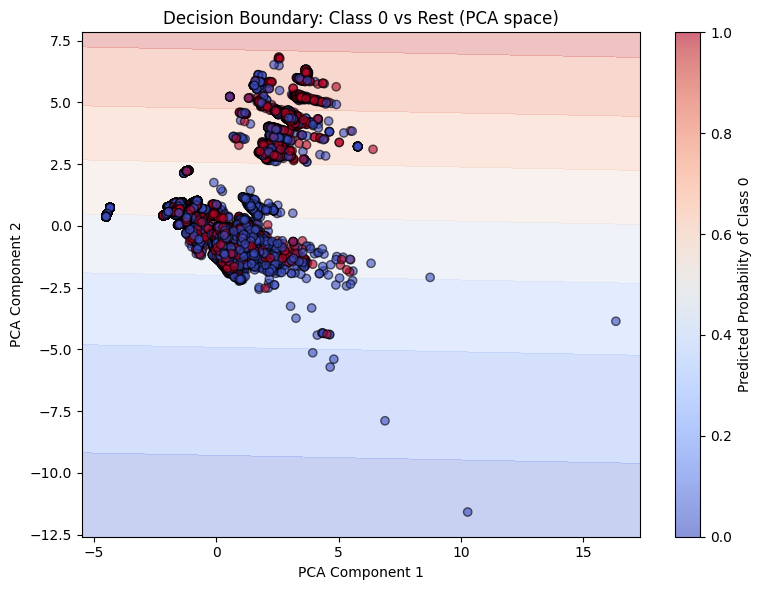

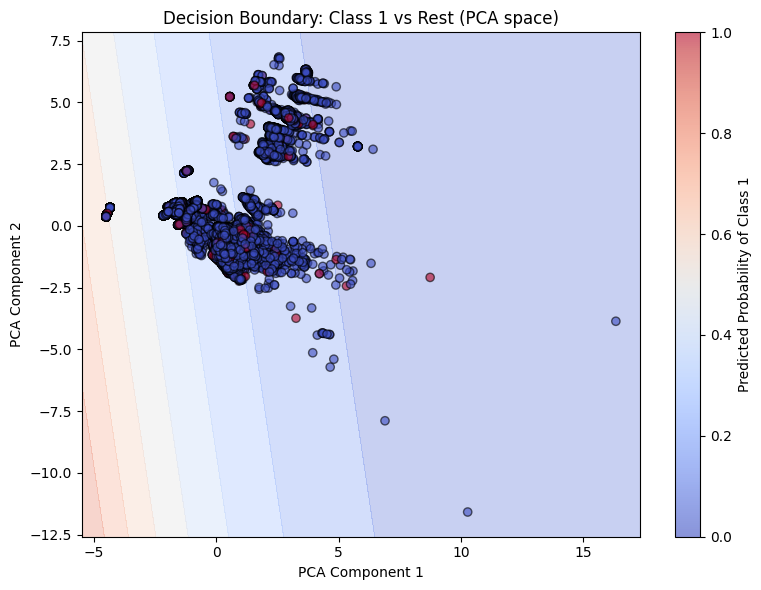

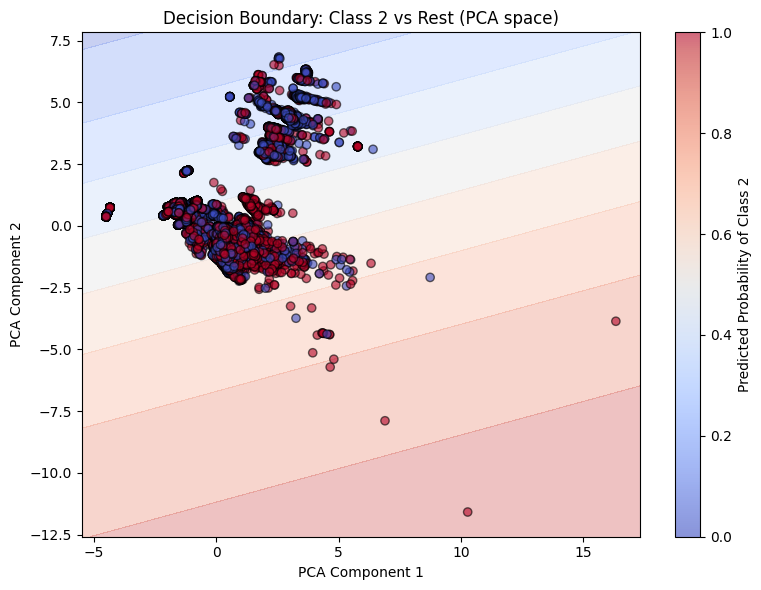

In [163]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Keep only numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Step 3: Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Loop through each class
unique_classes = np.unique(y)  # e.g., [0, 1, 2]

for cls in unique_classes:
    # Create binary target: 1 for current class, 0 for others
    y_binary = (y == cls).astype(int)

    # Train 1-vs-rest classifier
    clf = LogisticRegression()
    clf.fit(X_pca, y_binary)

    # Generate meshgrid for decision boundary
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, edgecolors='k',
                cmap='coolwarm', alpha=0.6)
    plt.title(f"Decision Boundary: Class {cls} vs Rest (PCA space)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label=f"Predicted Probability of Class {cls}")
    plt.tight_layout()
    plt.show()


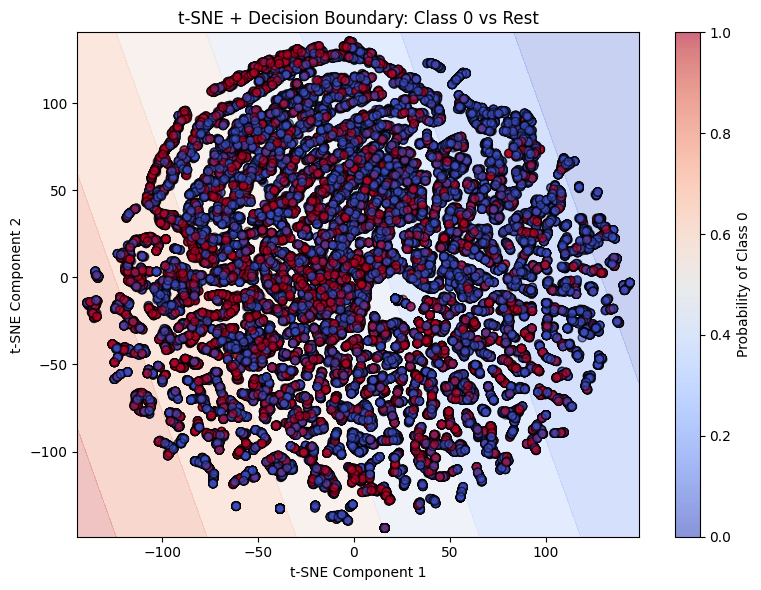

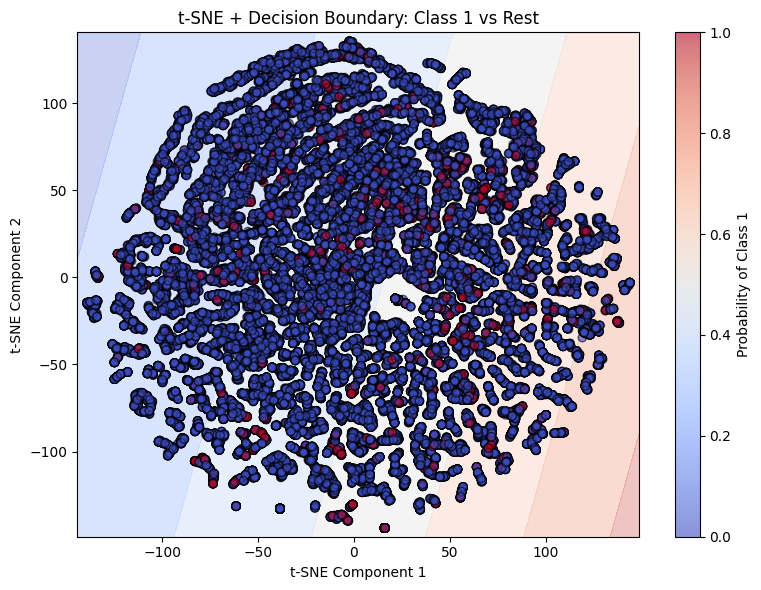

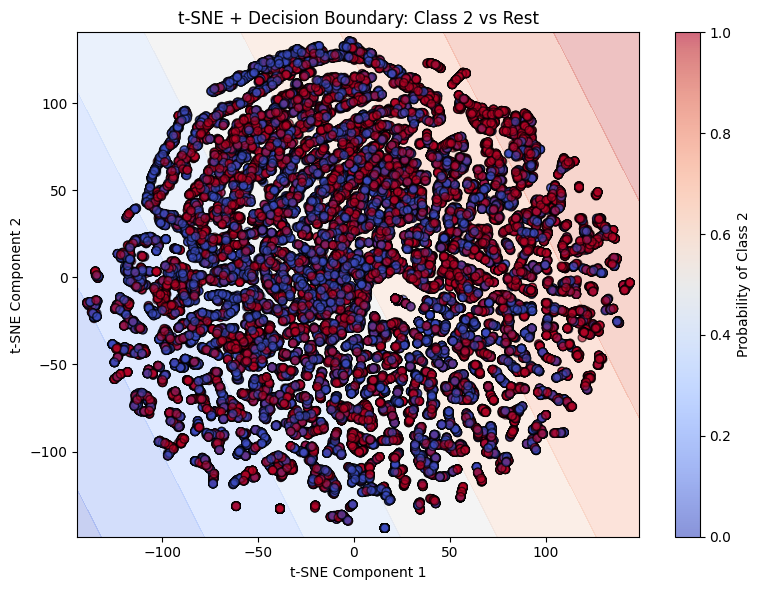

In [164]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_numeric)  # X_numeric: only numeric features

# Step 2: Loop through each class for 1-vs-rest
for cls in np.unique(y):
    y_binary = (y == cls).astype(int)

    clf = LogisticRegression()
    clf.fit(X_tsne, y_binary)

    # Decision boundary
    x_min, x_max = X_tsne[:, 0].min() - 5, X_tsne[:, 0].max() + 5
    y_min, y_max = X_tsne[:, 1].min() - 5, X_tsne[:, 1].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_binary, edgecolors='k',
                cmap='coolwarm', alpha=0.6)
    plt.title(f"t-SNE + Decision Boundary: Class {cls} vs Rest")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.colorbar(label=f"Probability of Class {cls}")
    plt.tight_layout()
    plt.show()


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb

import pandas as pd

# Automatically select column types
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Define classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}


In [11]:
from sklearn.pipeline import Pipeline

# Build pipelines
pipelines = {
    name: Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ]) for name, model in models.items()
}


In [12]:
from sklearn.metrics import classification_report
import pandas as pd

results = {}

for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report["weighted avg"]


Training Decision Tree...


KeyboardInterrupt: 

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results).T
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=results_df)
